In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_dir = "/content/drive/MyDrive/valorant_skins_dataset"  # Change to your dataset path


print("Weapon Categories:", os.listdir(data_dir))


Weapon Categories: ['melee', 'sheriff', 'spectre', 'shorty', 'odin', 'outlaw', 'operator', 'stinger', 'vandal', 'phantom', 'guardian', 'classic', 'marshal', 'ares', 'bulldog', 'frenzy', 'ghost', 'judge', 'bucky']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Set up batch size and image size
batch_size = 32
img_size = (224, 224)  # Resize images

# Set a seed for reproducibility
seed = 123  # You can use any integer value here

# Load the training dataset (80% of the data, for example)
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% data for validation
    subset="training",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    seed=seed  # Provide the seed value here
)

# Load the validation dataset (20% of the data, for example)
test_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% data for validation
    subset="validation",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    seed=seed  # Provide the seed value here
)

# Check class names (weapon types)
class_names = train_ds.class_names
print("Classes:", class_names)


Found 2238 files belonging to 19 classes.
Using 1791 files for training.
Found 2238 files belonging to 19 classes.
Using 447 files for validation.
Classes: ['ares', 'bucky', 'bulldog', 'classic', 'frenzy', 'ghost', 'guardian', 'judge', 'marshal', 'melee', 'odin', 'operator', 'outlaw', 'phantom', 'sheriff', 'shorty', 'spectre', 'stinger', 'vandal']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # 18 classes
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,171,411 (42.62 MB)

 Trainable params: 11,171,411 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf

# Create the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,  # Stop as soon as the validation loss does not improve
    restore_best_weights=True  # Restore the best model weights (i.e., the one with the lowest val_loss)
)

# Train the model with early stopping
epochs = 10
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    batch_size=32,
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 641s 11s/step - accuracy: 0.3716 - loss: 2.2237 - val_accuracy: 0.9284 - val_loss: 0.2616
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 52s 175ms/step - accuracy: 0.9751 - loss: 0.1256 - val_accuracy: 0.9485 - val_loss: 0.1796
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.9879 - loss: 0.0575 - val_accuracy: 0.9821 - val_loss: 0.1082
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.9959 - loss: 0.0175 - val_accuracy: 0.9843 - val_loss: 0.1311
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.9953 - loss: 0.0195 - val_accuracy: 0.9709 - val_loss: 0.1452
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 0.9928 - loss: 0.0351 - val_accuracy: 0.9709 - val_loss: 0.1398


In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Get predictions from the model
yp = model.predict(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9906 - loss: 0.0580
Test Loss: 0.10821102559566498, Test Accuracy: 0.9821029305458069
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


In [ ]:
model.save("valorant_skin_recognition.h5")

In [ ]:
from google.colab import files
files.download("valorant_skin_recognition.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


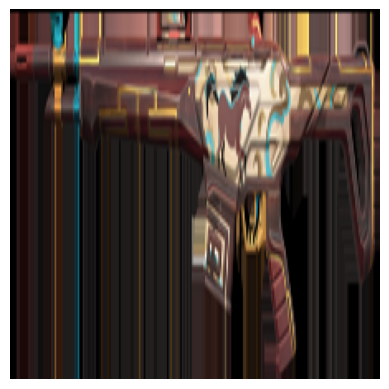

Actual label: guardian
Predicted label: guardian


In [ ]:
import matplotlib.pyplot as plt
# Choose a specific index (e.g., the 10th image in the dataset)
index = 10
image_batch, label_batch = list(test_ds.take(1))[0]  # Take the first batch
img = image_batch[index].numpy().astype("float32")

# Scale the image to [0, 255] for display
img = (img * 255).astype("uint8")

# Get the predicted label for this image
yp = model.predict(image_batch)
predicted_label = class_names[yp[index].argmax()]

# Get the actual label for this image
actual_label = class_names[label_batch[index].numpy()]

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the actual and predicted labels
print(f"Actual label: {actual_label}")
print(f"Predicted label: {predicted_label}")
